In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from qutip import *
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import simpson
from scipy import stats
plt.rcParams.update({'font.size': 14})

In [2]:
def model(z,t,myu,q0):
    omega=1
    x=z[0]
    y=z[1]
    dxdt=omega*y
    dydt=-myu*dxdt*(x**2-q0**2)-omega*x
    dzdt=[dxdt,dydt]
    return dzdt
def coper(N,q0,myu):
    cops=[]
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    const1=myu*(q0**2-1)
    const2=3*myu/4
    c1=sqrt(const1)*adag
    c2=sqrt(const2)*a**2
    c3=sqrt(myu)*(adag*a-0.5*adag**2)
    cops.append(c1)
    cops.append(c2)
    cops.append(c3)
    return cops
def hamil(N,omega,q0,myu):
    a=destroy(N)
    adag=a.dag()
    zeta=myu/12
    beta=myu/24
    eta=myu*(q0**2-1)/4
    H=omega*adag*a+(1j*zeta*(adag*a**3-(adag**3)*a))+(1j*beta*(a**4-adag**4))-(1j*eta*(a**2-adag**2))
    return H
def retdiag(rho,N):
    rhoii=[]
    n=[]
    for i in range(N):
        rhoii.append(rho.diag())
        n.append(i+1)
    return n,rhoii
def retdens(H,cops,N):
    expop=rand_dm(N)
    times = np.linspace(0.0, 100.0, 10000)
    result_dm = mesolve(H, expop, times, cops)
    return result_dm.states    
def Gauss(x, A, B, C):
    y = A*np.exp(-((x-B)/C)**2)
    return y
def expdecay(x,lam,A,C):
    y=A*np.exp(-lam*(x-C))
    return y
def linfit(x,lam,C):
    y=lam*x+C
    return y
def sinfreq(x,A,omega,phi):
    y=A*np.sin(omega*x+phi)
    return y
def eig(myu,qo,omega):
    e=[((myu*q0**2)+1j*sqrt(4*omega**2-(myu**2)*q0**4))/2,((myu*q0**2)-1j*sqrt(4*omega**2-(myu**2)*q0**4))/2]
    return e
def retindex(tl,period):
    index2=0
    t2=0
    t2=tl[0]+abs(period)
    epi=0.01
    for i in range(len(tl)):
        if tl[i]<=(t2+epi) and tl[i]>=(t2-epi):
            index2=i
    return index2
def jacob(omega,q0,myu,q,p):
    j=np.zeros((2,2))
    j[0][0]=0
    j[0][1]=omega
    j[1][0]=-2*myu*q*p-omega
    j[1][1]=-myu*(q**2-q0**2)
    return j
def floquet(omega,q0,myu,position,momentum,times,T):
    final=np.identity(2)
    I=np.identity(2)
    for i in range(len(times)):
        q=position[i]
        p=momentum[i]
        final=final*(I+(T/len(times))*(jacob(omega,q0,myu,q,p)))
    return final
def square(list):
    return [i ** 2 for i in list]
def tracnorm(A,B):
    C=A-B
    return ((C*C.dag())).sqrtm().tr()

In [3]:
q0=3
omega=1
N=30
x=np.linspace(-8,+8,200)
p=np.linspace(-8,+8,200)

In [4]:
myu=[0.001,0.009,0.03,0.05,0.07,0.1]
H=[]
cops=[]
ss=[]

In [5]:
for i in range(len(myu)):
    m=myu[i]
    h=hamil(N,omega,q0,m)
    c=coper(N,q0,m)
    s=steadystate(h,c)
    H.append(h)
    cops.append(c)
    ss.append(s)

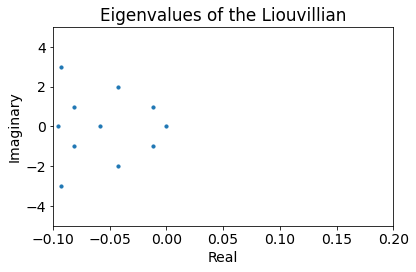

In [9]:
lo=liouvillian(H[1], cops[1])
el=lo.eigenenergies()
ev=lo.eigenstates()
x = [ele.real for ele in el]
y = [ele.imag for ele in el]

plt.scatter(x, y,s=10)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Eigenvalues of the Liouvillian')
plt.xlim(-0.1,0.2)
plt.ylim(-5,5)
#plt.savefig('lioeigenin.png')
plt.tight_layout()
plt.show()


In [10]:
img_ev=[]


for i in range(len(el)):
    if (el[i].real< 1.0e-13) and (el[i].real > -1.0e-13)  :
        
        img_ev.append(el[i])
        
    elif el[i].real==0:
        img_ev.append(el[i])
        
img_ev1=[]

for i in range(len(img_ev)):
    if (math.trunc(img_ev[i].imag)!=0):
        
        
        
        img_ev1.append(img_ev[i]) 
        

In [11]:
smallel=[]
for i in range(len(myu)):
    lo=liouvillian(H[i], cops[i])
    el=lo.eigenenergies()
    realel=[]
    realel = [-ele.real for ele in el]
    smallel.append(realel[-2]-realel[-1])
        
    

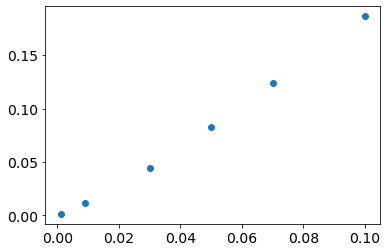

In [12]:
plt.scatter(myu,smallel)

In [14]:
lamb=[-0.00036594, -0.00297615, -0.01151289, -0.01877152, -0.02548312,
       -0.03810707]

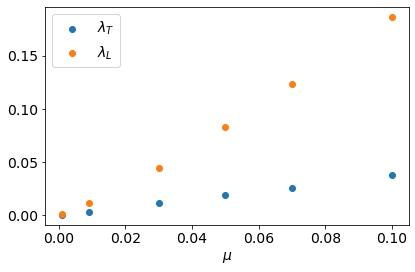

In [29]:
plt.scatter(myu,np.abs(lamb),label=r'$\lambda_T$')
plt.scatter(myu,smallel,label=r'$\lambda_L$')
plt.xlabel(r'$\mu$')
plt.legend()
plt.tight_layout()
plt.savefig('liotracecomp.png')


In [18]:
flexp=[-0.0035339617294815277,
 -0.07812232131595394,
 -0.27245448225588853,
 -0.4593171640883984,
 -0.6509590318546369,
 -0.9599822867872988]

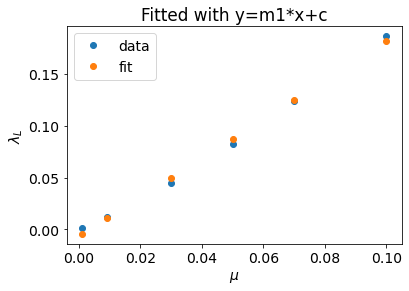

In [19]:
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, myu, smallel,p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
fit_y=linfit(np.asarray(myu),fit_A,fit_B)
plt.plot (myu, smallel, 'o', label='data')
plt.plot(myu, fit_y, 'o', label='fit')
plt.legend()
plt.ylabel(r'$\lambda_L$')
plt.xlabel(r'$\mu$')
plt.title('Fitted with y=m1*x+c')
plt.tight_layout()
#plt.savefig('lammyufit.png')

In [20]:
m1=fit_A

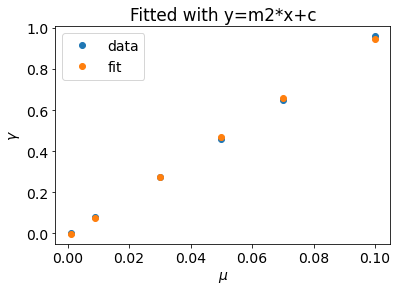

In [21]:
guess=np.random.rand(2)
parameters1, covariance1 = curve_fit(linfit, myu, np.abs(flexp),p0=guess)
fit_A = parameters1[0]
fit_B = parameters1[1]
fit_y=linfit(np.asarray(myu),fit_A,fit_B)
plt.plot (myu, np.abs(flexp), 'o', label='data')
plt.plot(myu, fit_y, 'o', label='fit')
plt.legend()
plt.ylabel(r'$\gamma$')
plt.xlabel(r'$\mu$')
plt.title('Fitted with y=m2*x+c')
#plt.savefig('lammyufitforlio.png')

In [22]:
m2=fit_A

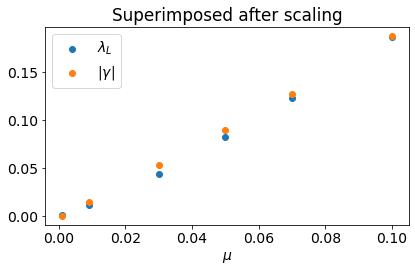

In [30]:
plt.scatter(myu,np.abs(smallel),label=r'$\lambda_L$')
plt.scatter(myu,(m1/m2)*np.asarray(np.abs(flexp)),label=r'$|\gamma|$')
plt.legend()
plt.xlabel(r'$\mu$')
plt.title('Superimposed after scaling')
plt.tight_layout()
plt.savefig("lamliogamsuper.png")

In [24]:
m1/m2

0.19554790497801045

In [25]:
m1

1.8785869600040406

In [17]:
np.exp(smallel)

array([1.00123466, 1.0116751 , 1.04568704, 1.08611037, 1.1316253 ,
       1.2049545 ])